In [1]:
%load_ext autoreload
%autoreload 2

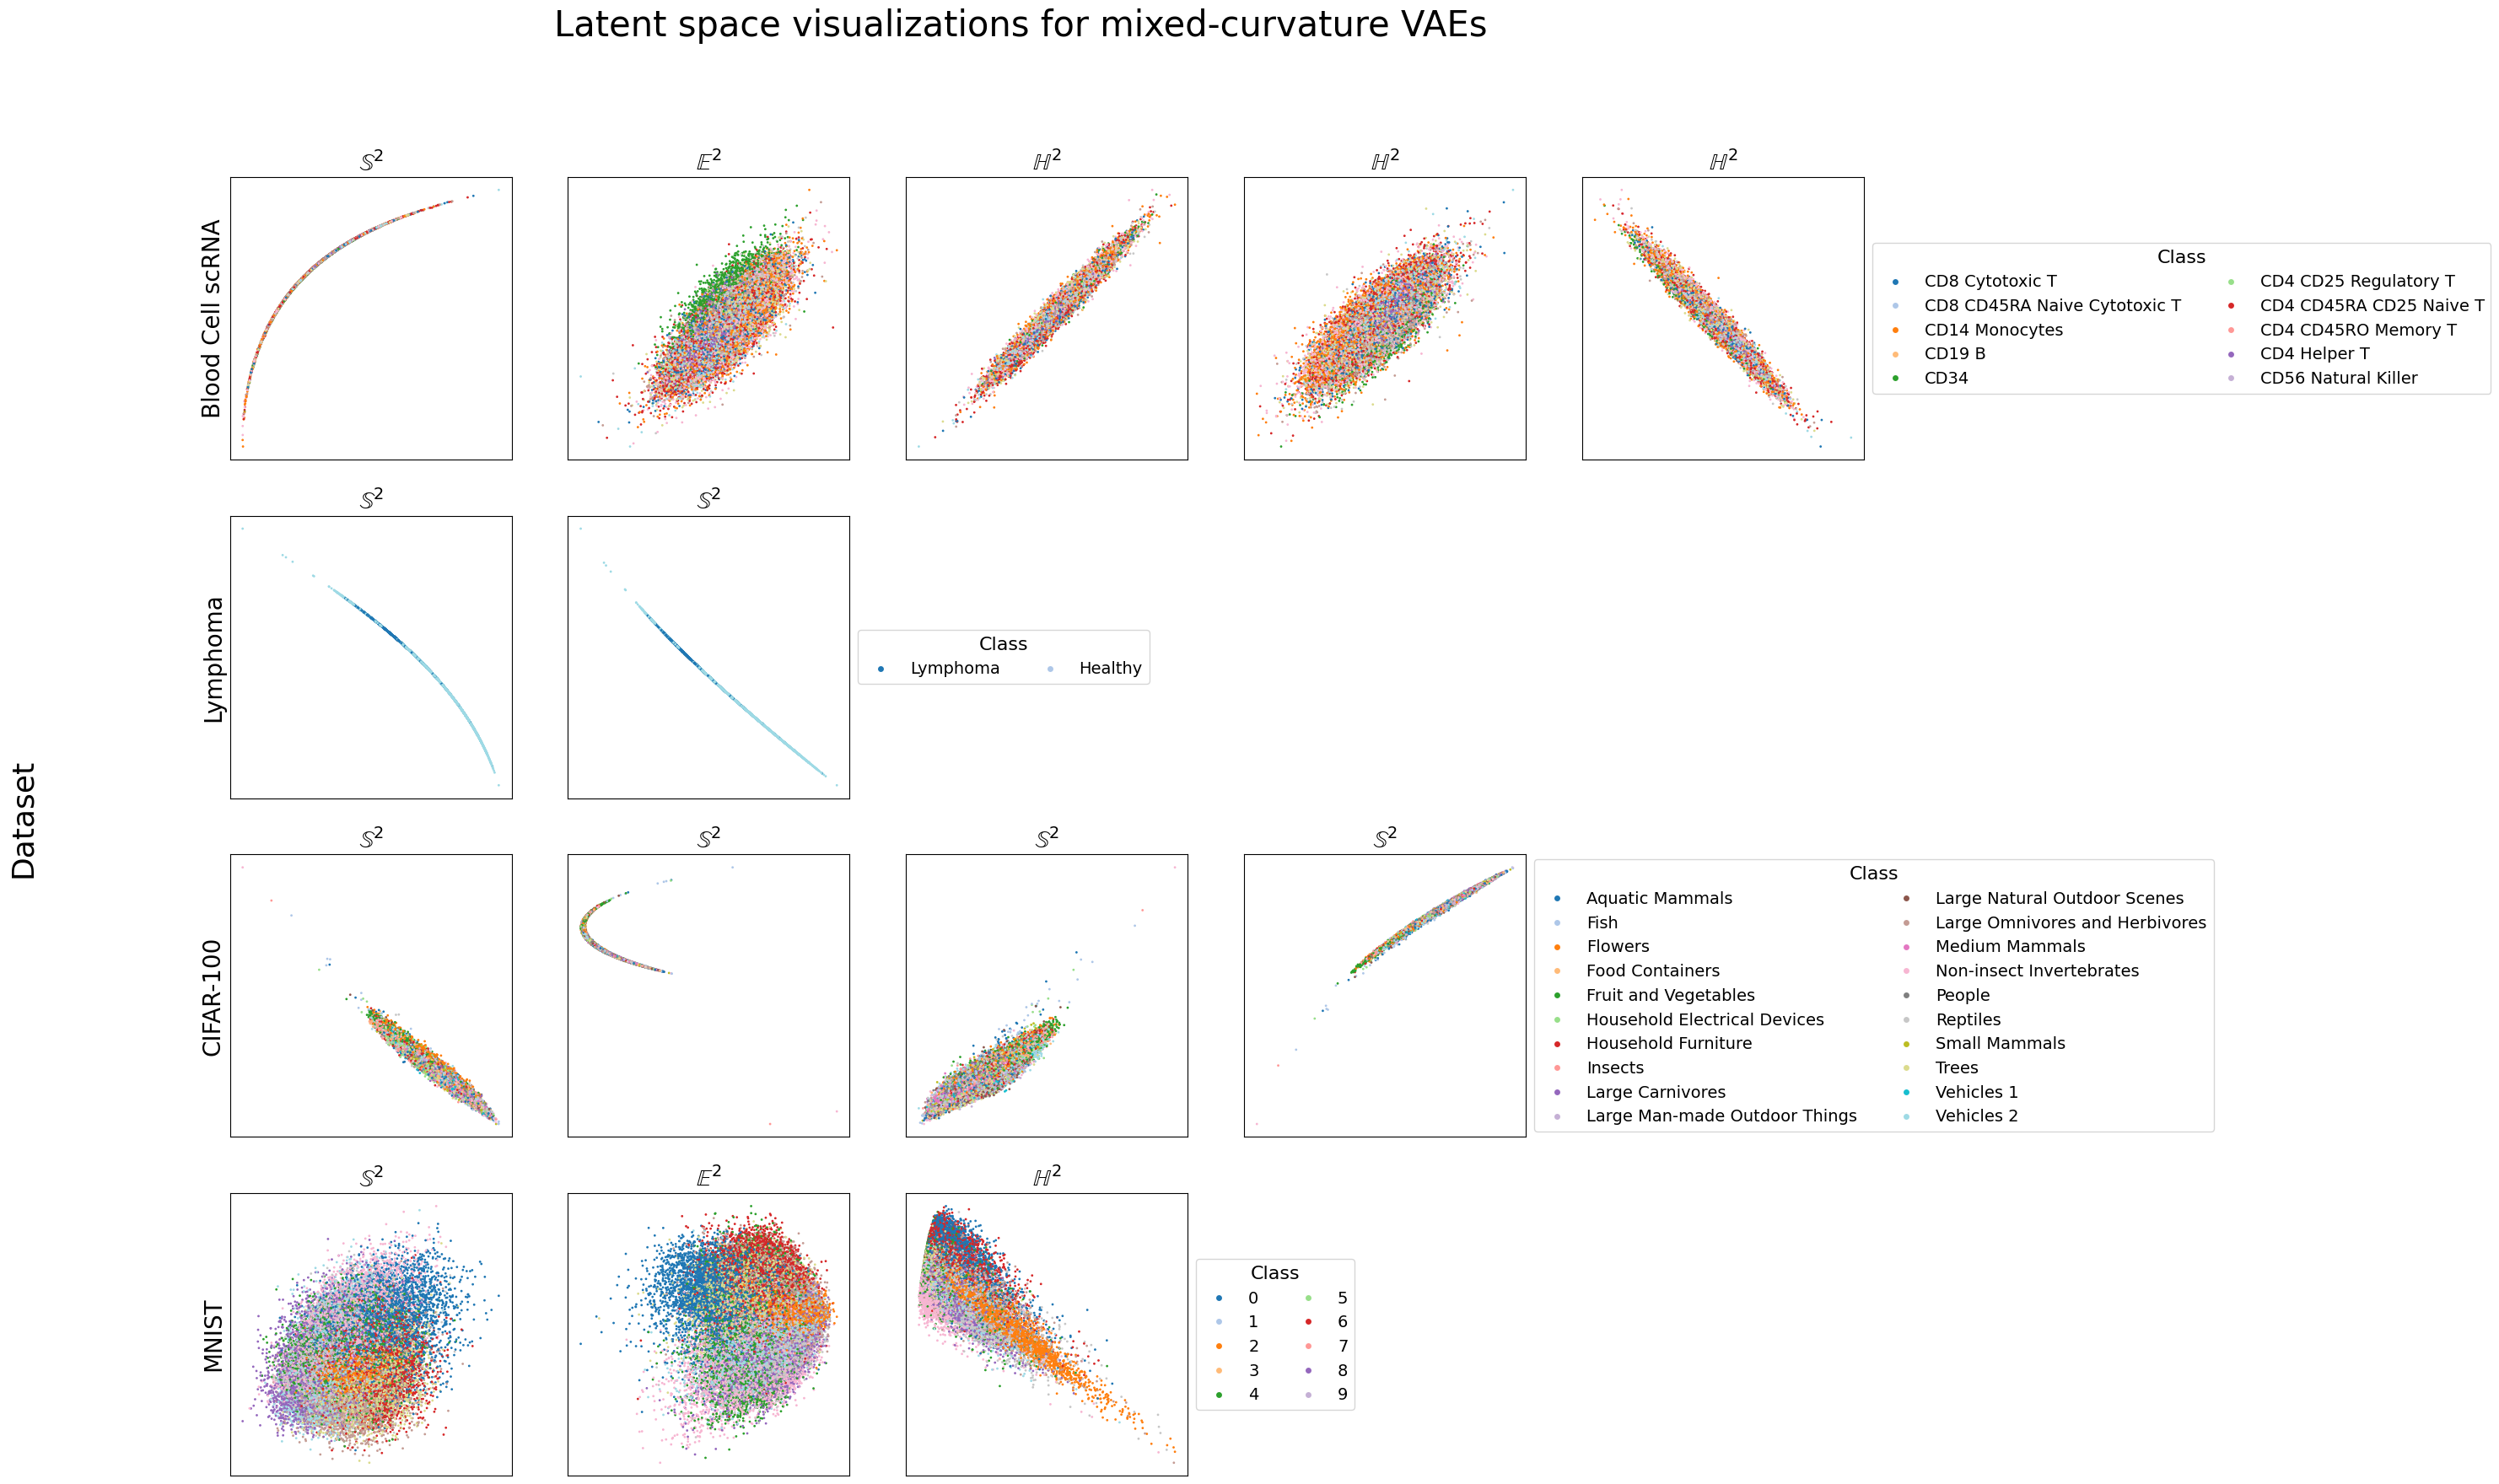

In [34]:
import numpy as np
import torch
import embedders
import matplotlib.pyplot as plt

embeddings = [
    "blood_cell_scrna",
    "lymphoma",
    "cifar_100",
    "mnist",
]
embeddings_names = [
    "Blood Cell scRNA",
    "Lymphoma",
    "CIFAR-100",
    "MNIST",
]
sigs = [
    [(1, 2), (0, 2), (-1, 2), (-1, 2), (-1, 2)],
    [(1, 2), (1, 2)],
    [(1, 2), (1, 2), (1, 2), (1, 2)],
    [(1, 2), (0, 2), (-1, 2)],
]
classes = [
    [
        "CD8 Cytotoxic T",
        "CD8 CD45RA Naive Cytotoxic T",
        "CD14 Monocytes",
        "CD19 B",
        "CD34",
        "CD4 CD25 Regulatory T",
        "CD4 CD45RA CD25 Naive T",
        "CD4 CD45RO Memory T",
        "CD4 Helper T",
        "CD56 Natural Killer",
    ],
    ["Lymphoma", "Healthy"],
    [
        "Aquatic Mammals",
        "Fish",
        "Flowers",
        "Food Containers",
        "Fruit and Vegetables",
        "Household Electrical Devices",
        "Household Furniture",
        "Insects",
        "Large Carnivores",
        "Large Man-made Outdoor Things",
        "Large Natural Outdoor Scenes",
        "Large Omnivores and Herbivores",
        "Medium Mammals",
        "Non-insect Invertebrates",
        "People",
        "Reptiles",
        "Small Mammals",
        "Trees",
        "Vehicles 1",
        "Vehicles 2",
    ],
    [str(i) for i in range(10)],
]
n_trials = 10

fig, axs = plt.subplots(4, 5, figsize=(25, 20))
for embedding, embedding_name, sig, ax_row, labels in zip(embeddings, embeddings_names, sigs, axs, classes):
    X_train = np.load(f"../data/{embedding}/embeddings/X_train_0.npy")
    X_test = np.load(f"../data/{embedding}/embeddings/X_test_0.npy")
    X = np.concatenate([X_train, X_test], axis=0)

    y_train = np.load(f"../data/{embedding}/embeddings/y_train_0.npy")
    y_test = np.load(f"../data/{embedding}/embeddings/y_test_0.npy")
    y = np.concatenate([y_train, y_test], axis=0)

    # Convert to tensors
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

    pm = embedders.manifolds.ProductManifold(signature=sig)

    # Plot each submanifold
    for i, (ax, M) in enumerate(zip(ax_row, pm.P)):
        to_plot = X[:, pm.man2dim[i]]
        if M.type == "S":
            to_plot = embedders.visualization.S2_to_polar(to_plot)
        elif M.type == "H":
            to_plot = embedders.visualization.hyperboloid_to_poincare(to_plot)
        to_plot = to_plot.numpy()
        ax.set_title("$\mathbb{" + M.type + "}^" + str(M.dim) + "$", fontsize=20)
        ax.scatter(to_plot[:, 0], to_plot[:, 1], s=1, c=y.numpy(), cmap="tab20", rasterized=True)

    # Turn off remaining axes
    n = len(pm.P)
    for ax in ax_row[n:]:
        ax.axis("off")

    # No ticks
    for ax in ax_row:
        ax.set_xticks([])
        ax.set_yticks([])

    # Label on left side
    ax_row[0].set_ylabel(embedding_name, fontsize=20)

    # Add a legend for the last non-empty plot
    # ax_row[n-1].legend(*ax_row[n-1].get_legend_handles_labels(), loc="center left", bbox_to_anchor=(1, 0.5))
    # We need to fake a legend after the fact
    legend_elements = [
        plt.Line2D([0], [0], marker="o", color="w", label=str(i), markerfacecolor=plt.cm.tab20(i))
        for i in range(len(np.unique(y)))
    ]
    ax_row[n - 1].legend(
        handles=legend_elements,
        labels=labels,
        title="Class",
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        fontsize=14,
        title_fontsize=16,
        ncol=2,
    )

fig.supylabel("Dataset", rotation=90, fontsize=26)
plt.suptitle("Latent space visualizations for mixed-curvature VAEs", fontsize=30)
plt.tight_layout()

plt.savefig("../figures/mixed_curvature_vae_visualizations.pdf", bbox_inches="tight")